In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K 
from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [2]:
model = tf.keras.models.load_model("./cvae_model_20210918_keras.h5", custom_objects={'Sampling': Sampling})

In [3]:
decoder = model.get_layer("decoder")

In [34]:
a = decoder.predict([[0.7 for x in range(64)]])

In [35]:
a.shape

(1, 180, 180, 1)

(-0.5, 179.5, 179.5, -0.5)

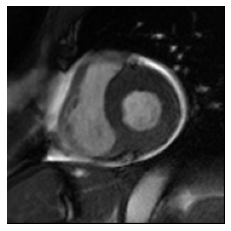

In [16]:
plt.imshow(a[:,:,0].astype("float32"))
plt.axis('off')
# plt.savefig("im_origin.png", bbox_inches='tight')

In [10]:
import numpy as np
a = np.load("images/im_13.npy")

In [4]:
encoder = model.get_layer("encoder")

In [11]:
x = encoder.predict(a[None, :, :, :])[-1]

In [12]:
im = decoder.predict(x)

(-0.5, 179.5, 179.5, -0.5)

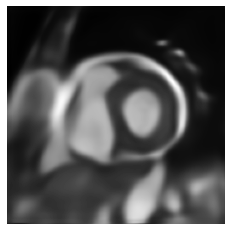

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.imshow(im[0,:,:,0])
plt.axis('off')
# plt.savefig("im_predict.png", bbox_inches='tight')

In [57]:
plt.savefig("im_predict.png")

array([[ 1.0856228e+00, -9.6924180e-01,  5.0050080e-01,  2.8793371e-01,
         1.7727703e+00,  8.0334878e-01, -1.2016700e-01, -3.8358453e-01,
        -3.9468297e-01, -1.1846510e+00,  1.0790305e+00,  3.5570920e-01,
         9.8078710e-01,  6.1903054e-01,  1.6772296e+00, -3.2154343e-01,
         1.2230061e-01, -7.1128684e-01, -6.9070160e-01, -9.2417711e-01,
        -3.7308529e-01, -1.5434192e+00, -2.9024023e-01,  1.0369263e+00,
        -1.5858043e+00,  9.3407428e-01,  1.4072700e+00,  6.9169909e-01,
        -3.3018872e-01, -2.9622668e-01, -2.4766058e-02,  6.1582202e-01,
         3.6270487e-01, -1.6877372e+00,  1.0951036e+00, -1.7011882e+00,
         9.5312721e-01, -2.6826385e-01,  5.5147201e-01, -1.9942987e+00,
         8.3091182e-01, -1.4205334e+00,  8.4068537e-01,  2.2970885e-03,
         1.1938757e+00, -2.8908125e-03,  3.6247492e-01, -8.1193417e-02,
         8.6170691e-01,  7.9409736e-01,  8.0458307e-01,  7.5112963e-01,
         4.4027680e-01,  7.2389096e-01,  5.2495301e-04,  1.42292

In [58]:
# content_image = im  
content_image = np.repeat(im, 3, axis=-1)
# style_image = a[None, ...] 
style_image = np.repeat(a[None, ...].astype("float32"), 3, axis=-1)

# Transfer Style 

In [14]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'


In [15]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


In [16]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)


## Transferencia rapida - TFHub  

In [28]:
print(f"Content image shape: {content_image.shape}; Style image shape: {style_image.shape}")
print(f"Content image type: {content_image.dtype}; Style image type: {style_image.dtype}")

import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)


Content image shape: (1, 180, 180, 3); Style image shape: (1, 180, 180, 3)
Content image type: float32; Style image type: float32


ModuleNotFoundError: No module named 'tensorflow_hub'

## Construir modelo 

In [59]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# content_layers = ['conv2d_603'] 

# style_layers = [f"conv2d_{597+x}" for x in range(6)]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


### Construye el modelo 

In [60]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#     vgg = tf.keras.models.load_model("./cvae_model_20210918_keras.h5", custom_objects={'Sampling': Sampling}).get_layer("encoder")
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [61]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()


block1_conv1
  shape:  (1, 180, 180, 64)
  min:  0.0
  max:  818.5
  mean:  10.17

block2_conv1
  shape:  (1, 90, 90, 128)
  min:  0.0
  max:  2808.0
  mean:  69.1

block3_conv1
  shape:  (1, 45, 45, 256)
  min:  0.0
  max:  4940.0
  mean:  77.6

block4_conv1
  shape:  (1, 22, 22, 512)
  min:  0.0
  max:  7520.0
  mean:  314.5

block5_conv1
  shape:  (1, 11, 11, 512)
  min:  0.0
  max:  1198.0
  mean:  27.6



### Calcular estilo 

In [62]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


### Extraer estilo y contenido 

In [63]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
#         preprocessed_input = inputs  
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [65]:
tf.keras.backend.set_floatx('float32')
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  42537.38
    mean:  385.09534

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  48784.918
    mean:  8645.695

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  566893.8
    mean:  9667.8

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2841462.5
    mean:  137450.33

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  73599.54
    mean:  768.09406

Contents:
   block5_conv2
    shape:  (1, 11, 11, 512)
    min:  0.0
    max:  578.8583
    mean:  9.244956


### Ejecutar descenso de gradiente 

In [66]:
# tf.keras.backend.set_floatx('float16')
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [43]:
image = tf.Variable(content_image)

In [44]:
def clip_0_1(image):
      return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [45]:
opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

In [67]:
def style_content_loss(outputs, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


In [47]:
style_weight=1e-10
content_weight=1e13
image = tf.Variable(content_image)

In [ ]:
def create_train_step(lr=0.005):
    opt = tf.optimizers.Adam(learning_rate=lr, beta_1=0.99, epsilon=1e-1)
    @tf.function()
    def train_step(image, style_weight, content_weight):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs, style_weight, content_weight)

        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))
    return train_step

    
def transfer_style_matrix(lr_list, style_weight_list, content_weight_list, epochs):
    for lr in lr_list:
        for style_weight in style_weight_list:
            for content_weight in content_weight_list:
                try:
                    image = tf.Variable(content_image)
                    train_step = create_train_step(lr)
                    for _ in range(epochs):
                        train_step(image, style_weight, content_weight)
                    print(f"transfer_style_images/im_13_{lr:.0e}_{style_weight:.0e}_{content_weight:.0e}.npy")
                    np.save(f"transfer_style_images/im_13_{lr:.0e}_{style_weight:.0e}_{content_weight:.0e}.npy", image.numpy())
                except Exception as e:
                    print(f"Error with lr: {lr:.0e}; style_weight: {style_weight:.0e}; content_weight: {content_weight:.0e}\n", e)



transfer_style_matrix([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001], [10**x for x in range(-15,17)], [10**x for x in range(-15,17)], 1000) 

transfer_style_images/im_13_5e-02_1e-15_1e-15.npy
transfer_style_images/im_13_5e-02_1e-15_1e-14.npy
transfer_style_images/im_13_5e-02_1e-15_1e-13.npy
transfer_style_images/im_13_5e-02_1e-15_1e-12.npy
transfer_style_images/im_13_5e-02_1e-15_1e-11.npy
transfer_style_images/im_13_5e-02_1e-15_1e-10.npy
transfer_style_images/im_13_5e-02_1e-15_1e-09.npy
transfer_style_images/im_13_5e-02_1e-15_1e-08.npy
transfer_style_images/im_13_5e-02_1e-15_1e-07.npy
transfer_style_images/im_13_5e-02_1e-15_1e-06.npy
transfer_style_images/im_13_5e-02_1e-15_1e-05.npy
transfer_style_images/im_13_5e-02_1e-15_1e-04.npy
transfer_style_images/im_13_5e-02_1e-15_1e-03.npy
transfer_style_images/im_13_5e-02_1e-15_1e-02.npy
transfer_style_images/im_13_5e-02_1e-15_1e-01.npy
transfer_style_images/im_13_5e-02_1e-15_1e+00.npy
transfer_style_images/im_13_5e-02_1e-15_1e+01.npy
transfer_style_images/im_13_5e-02_1e-15_1e+02.npy
transfer_style_images/im_13_5e-02_1e-15_1e+03.npy
transfer_style_images/im_13_5e-02_1e-15_1e+04.npy


In [65]:
print([10**x for x in range(-15,17)])

[1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000, 10000000000000, 100000000000000, 1000000000000000, 10000000000000000]


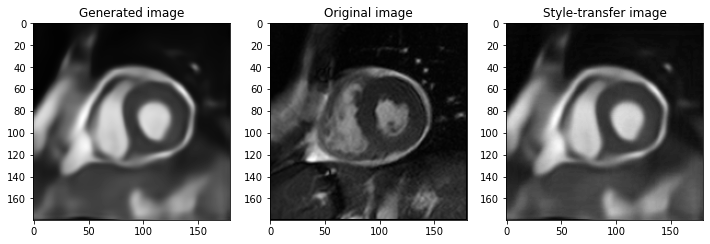

In [44]:
# train_step(image)
# train_step(image)
train_step(image)
# tensor_to_image(image[0,:,:,:])
plot_images(content_image, style_image, image)

In [43]:
def plot_images(content_image, style_image, image):
    plt.subplot(1,3,1)
    plt.title("Generated image")
    plt.imshow(content_image[0, :,:,0])
    plt.subplot(1,3,2)
    plt.title("Original image")
    plt.imshow(style_image[0, :,:,0])
    plt.subplot(1,3,3)
    plt.title("Style-transfer image")
    plt.imshow(image[0, :,:,0])

In [10]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [11]:
ims_list = [(np.load("./images/"+x), decoder.predict(encoder.predict(np.load("./images/"+x)[None, :, :, :])[-1]), "./images/"+x) for x in os.listdir("./images") if x.endswith(".npy")]

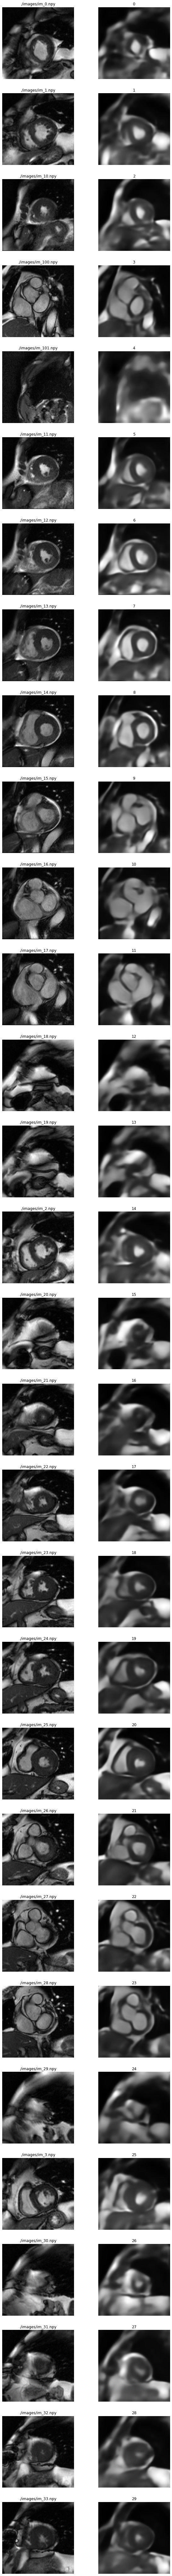

In [20]:
plt.figure(figsize=(10,150))
plt.set_cmap("gray")
for i, im in enumerate(ims_list):
    if i==30:
        break
#     print(im)
    plt.subplot(30,2,2*i+1)
    plt.imshow(im[0].astype("float32"))
    plt.axis("off")
    plt.title(im[2])
    plt.subplot(30,2,2*i+2)
    plt.imshow(im[1][0,...,0].astype("float32"))
    plt.axis("off")
    plt.title(i)

./images/im_14.npy


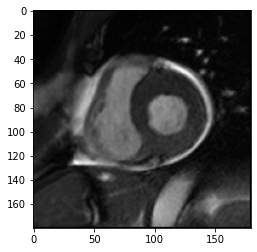

In [11]:
im = ims_list[8]
print(im[1])
plt.imshow(im[0].astype("float32"))

In [ ]:
content_layers = ['conv2_603'] 

style_layers = [f"conv2d_{597+x}" for x in range(6)]


In [8]:
encoder.summary()
# vgg.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 180, 180, 1) 0                                            
__________________________________________________________________________________________________
conv2d_597 (Conv2D)             (None, 90, 90, 4)    40          input_53[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_571 (LeakyReLU)     (None, 90, 90, 4)    0           conv2d_597[0][0]                 
__________________________________________________________________________________________________
conv2d_598 (Conv2D)             (None, 45, 45, 8)    296         leaky_re_lu_571[0][0]            
____________________________________________________________________________________________

In [9]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     